In [12]:
import numpy as np
import pickle
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats
from scipy.integrate import quad
from copy import deepcopy

from mutator_classes import Parameters
import stationary_distribution_aug as sd

sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 400
font_size = 10
mpl.rcParams['axes.titlesize'] = font_size
mpl.rcParams['axes.labelsize'] = font_size
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['legend.fontsize'] = font_size
mpl.rcParams['legend.title_fontsize'] = font_size


In [3]:
directory = '/Users/will_milligan/PycharmProjects/MUTATOR_FINAL/variableSelectedEffectResults/'
directory = '/Users/will_milligan/Desktop/control'
directory = '/Users/will_milligan/Desktop/limited_all'
directory = '/Users/will_milligan/Desktop/gamma'

files = os.listdir(directory)
results = {}
for f in files:
    
    if 'bin0_' in f: continue
    if '.tar.gz' in f: continue
#     print(f.split('_S'))
    S = eval(f.split('_S')[-1])
    name = os.path.join(os.path.join(directory,f),'all_results_summarized')
    try:
        with open(name,'rb') as fin:
            a = pickle.load(fin)
        results[10**S] = a
    except:
        print(name)
#     print(a)

In [4]:
def process_results(results = results):
    sim_results = {}
    for index,(S, (v,a)) in enumerate(results.items()):
        phi = a['phi']
        mean = (v['mean'][0]*2*phi,v['mean'][1]*2*phi)
        var  = (v['var'][0]*(2*phi)**2,v['var'][1]*(2*phi)**2)
        within = (v['within'][0]*(phi)**2,v['within'][1]*(phi)**2)
        
        if S < 1e-1:
            print(v['var'][0],var[0])
        sim_results[S] = {'mean':mean,'var':var,'within':within}
    return sim_results,a

sim_results,params = process_results()

0.24934016835977432 1.923921052158752e-21
0.2494802664843669 1.9250020562065351e-22


In [5]:
import numpy as np
from scipy.integrate import quad
from scipy import stats


# calculates the  stationary distribution for mutator alleles
def get_SD(p,sm=0,max_gen=1000,phi=None):

    # if phi is not provided, use the value contained within the parameters, p
    if not phi:
        phi = p.phi

    # calculate s^* (the strong selection approximation)
    cum_survival = expected_extra_mutations_somatic(p = p, max_gen = max_gen, sm = sm, phi = phi)
    new_s = (1 - sum(cum_survival[1:])/sum(cum_survival[:-1]))

    # these keep track of the possibilty
    zero_transition_prob = 0
    one_transition_prob  = 0

    # will become a discrete stationary distribution to sample from
    sd = {}

    # iterate over possible discrete allele values between 1 and 2N-1
    for i in np.linspace(1, 2 * p.N - 1, 2 * p.N - 1):

        # calculate the probability of moving to lost or fixed state
        transition_prob_0, transition_prob_1, density_at_x = get_probability_of_transition(p = p,
                                                                                             x = i / (2 * p.N),
                                                                                             new_s = new_s)

        sd[i / (2 * p.N)] = density_at_x
        zero_transition_prob += transition_prob_0
        one_transition_prob  += transition_prob_1

    # density at lost (or fixed) state is sum of probabilities moving there divided by the probability of moving away (e.g. prob of not having 0 mutations)
    sd[0]  = zero_transition_prob / (1 - stats.binom.pmf(0, 2 * p.N, p.mutator_mutation_rate))
    sd[1]  = one_transition_prob / (1 - stats.binom.pmf(0, 2 * p.N, p.mutator_mutation_rate))

    # density not at boundaries
    integrand = lambda q: freq_dep(x=q, p=p, new_s=new_s)
    density_not_at_boundaries = quad(integrand, 1 / (4 * p.N), 1 - 1 / (4 * p.N))[0]

    # calculate normalizing constant
    nc = sd[0] + sd[1] + density_not_at_boundaries
    assert np.isclose(nc,sum(sd.values()))

    # creates a discrete stationary distribution to sample from
    for i in sd.keys():
        sd[i] = sd[i] / nc

    return sd

# calculate probability of moving to either lost or fixed state weighted by density at x
def get_probability_of_transition(p, x, new_s):

    # calculates that non-normalized stationary density around x (specifically from x-1/(4N) to x+1/(4N))
    integrand = lambda q: freq_dep(x = q, p = p, new_s=new_s)
    density_at_x = quad(integrand, x - 1 / (4 * p.N), x + 1 / (4 * p.N))[0]

    # relative fitness of mutator allele
    selection_prob = 1 - new_s

    # probability of moving to the zero state AND having no mutations to the mutator allele
    zero_transition_prob = stats.binom.pmf(0, int(2 * p.N), selection_prob * x) * \
                           stats.binom.pmf(0, int((1 - x) * 2 * p.N), p.mutator_mutation_rate)

    # probability of moving to the fixed state AND having no mutations away from the mutator allele
    one_transition_prob = stats.binom.pmf(int(2 * p.N), int(2 * p.N), selection_prob * x) * \
                          stats.binom.pmf(0, int((x) * 2 * p.N), p.mutator_mutation_rate)


    return zero_transition_prob * density_at_x, one_transition_prob * density_at_x, density_at_x


# calculates that non-normalized stationary density at x
def freq_dep(x, p, new_s):
    s = new_s
    u = p.mutator_mutation_rate
    f = np.exp(-4 * p.N * s * x * (1 - x/2)) * (x * (1 - x)) ** (4 * p.N * u - 1)

    return f

def expected_extra_mutations_somatic(p, max_gen: int, phi, sm=0):
    mutation_curve = [0]
    cum_survival = [1]

    for gen in np.arange(1, max_gen):
        mutation_curve.append(mutation_curve[gen - 1] * (1/2) + p.loci * phi)
        exp_x = np.exp(-(mutation_curve[gen - 1])*p.h*p.s)*(1-sm)
        cum_survival.append(cum_survival[-1] * exp_x)

    return cum_survival






In [6]:
def calculate_analytics(params,phi,NE = 250):
    
    param_dict = deepcopy(params)
    param_dict['phi'] = phi
    new_params = Parameters(**param_dict)
    
    statdist = get_SD(new_params)
    
    mean_freq = sum([p*q for p,q in statdist.items()])
    mean = mean_freq*2*phi
    
    var_between_freq = sum([p**2*q for p,q in statdist.items()]) - mean_freq**2
    var_between = var_between_freq*(2*phi)**2
    
    var_within = sum([(1-p)*p*q for p,q in statdist.items()])*phi**2
    
    return (mean,var_between,var_within)
    

def get_params(params=None):

    simpleParams = False
    humanParams = False
    variableMutatorEffect = False
    variableSelectedEffect = True

    default_params = {'N': 20000,  # population size
                      'M': 1000,  # number of modifier loci, M
                      'h': 1,  # h
                      's': 0.001,  # s - together hs are the average fitness effects of mutations at selected loci
                      'phi': 0,  # effect size of mutator alleles
                      'mutator_mutation_rate': 1.25E-8,  # Mutation rate at modifier sites
                      'mutation_rate': 1.25E-8,  # baseline mutation rate at selected sites, u0
                      'loci': 3E9 * 0.08}  # number of selected loci
                
    small_N = 1000
    scaling_factor = 20000/small_N
    
    default_params['N'] = small_N
    for key in ['s','mutator_mutation_rate','mutation_rate']:
        default_params[key] = default_params[key]*scaling_factor
    default_params['loci'] = default_params['loci']/scaling_factor
    default_params['s'] = 0.015
    
    if params:
        print('here')
        return {k:params[k] for k in default_params.keys()}
        
    else:
        return default_params

def calculate_all_analytics(params,NE=int(250)):
    
    calc_phi = lambda p, S: S/(4 * p['N'] * p['loci'] * p['h'] * p['s'])

    results = {}
    for i,S in enumerate(np.logspace(-2, 3, 50)):
        if i % 10 == 0: print(i)
        phi = calc_phi(p = params,S=S)
        results[S] = calculate_analytics(phi = phi,NE = NE, params = params)
    return results

params = get_params(params=params)
analytic_results_1000 = calculate_all_analytics(params = params,NE=1000)
# analytic_results = calculate_all_analytics(params = params,NE=int(746.8328799999999))
print(params)

here
0
0.24947181276189817 1.9249368268664986e-22
0.24945661636178676 3.0794393738412624e-22
0.24943245391529942 4.926190735129263e-22
0.24939399030765794 7.8799938840894035e-22
0.24933270693839668 1.2603779048953482e-21
0.2492350046498535 2.015636434140552e-21
0.249079184363865 3.2227174399332587e-21
0.24883065525933662 5.1507480910564956e-21
0.24843436531329685 8.227345400320117e-21
0.24780293421008923 1.3129135691669311e-20
10
0.24679827766197832 2.0919603532666062e-20
0.24520373371810952 3.3252173399972444e-20
0.2426832448626985 5.2651940696585753e-20
0.23872525279826973 8.286184229133687e-20
0.23257472693031264 1.2915177382245463e-19
0.22317369611801602 1.9827250537111295e-19
0.20916910263900057 2.9730256364376593e-19
0.1891122979043809 4.3003373419181373e-19
0.16203138347350898 5.89472468953483e-19
0.12845610732028115 7.476541978302833e-19
20
0.09146738821534273 8.517142820738896e-19
0.05656444884681596 8.426609021919777e-19
0.029357396730148977 6.996944976787787e-19
0.0123850768

[1.9249368268664986e-22, 3.0794393738412624e-22, 4.926190735129263e-22, 7.8799938840894035e-22, 1.2603779048953482e-21, 2.015636434140552e-21, 3.2227174399332587e-21, 5.1507480910564956e-21, 8.227345400320117e-21, 1.3129135691669311e-20, 2.0919603532666062e-20, 3.3252173399972444e-20, 5.2651940696585753e-20, 8.286184229133687e-20, 1.2915177382245463e-19, 1.9827250537111295e-19, 2.9730256364376593e-19, 4.3003373419181373e-19, 5.89472468953483e-19, 7.476541978302833e-19, 8.517142820738896e-19, 8.426609021919777e-19, 6.996944976787787e-19, 4.722492273972879e-19, 2.523229832393589e-19, 1.0593694538024936e-19, 3.710878180261884e-20, 1.3201392770427554e-20, 5.926955458871599e-21, 3.546319581877455e-21, 2.766498205421526e-21, 2.512923817084722e-21, 2.4065621847319117e-21, 2.3525027686102385e-21, 2.330690486887488e-21, 2.3351230817275582e-21, 2.3640712989139045e-21, 2.4184555571529088e-21, 2.501465426897992e-21, 2.6186620554804713e-21, 2.778436769155077e-21, 2.9928417214396564e-21, 3.278894087

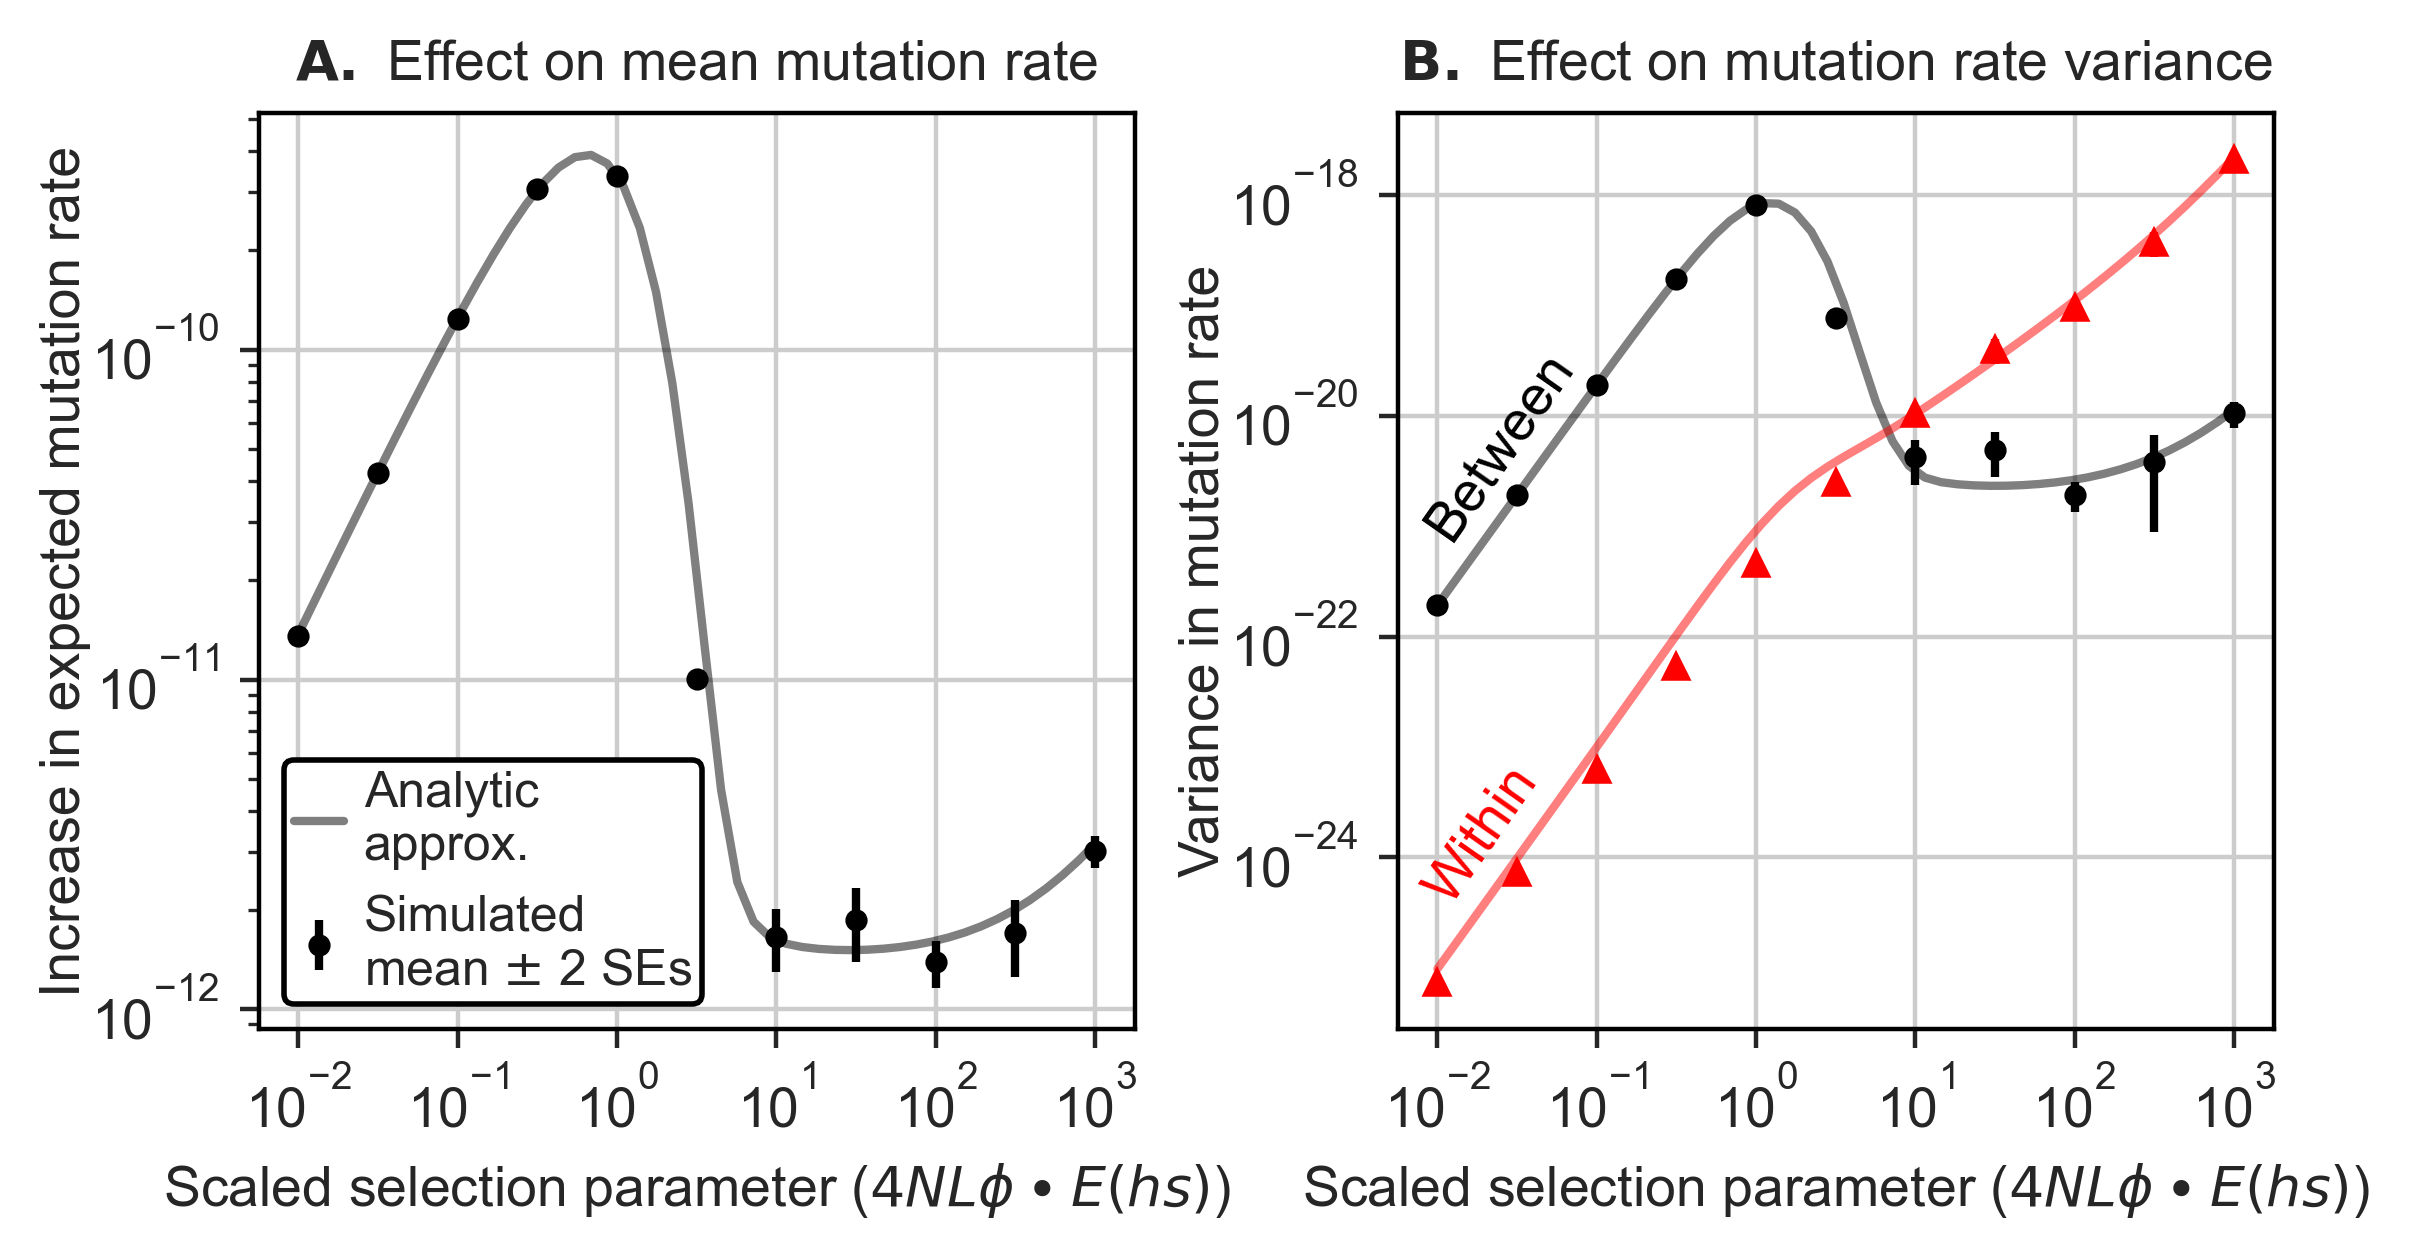

In [24]:
def mean_figure(ax,results = sim_results,
               scaling = 1):
    plt.sca(ax)
    
    
    for index,(S, v) in enumerate(results.items()):
        if index == 0:
            plt.errorbar(S,v['mean'][0]/scaling,
                         v['mean'][1]/scaling,
                         marker='.',ls='None',color='k',label='Simulated\n'+r'mean $\pm$ 2 SEs')
        else:
            plt.errorbar(S,v['mean'][0]/scaling,
                         v['mean'][1]/scaling,
                         marker='.',color='k')
             
    plt.plot([S for S in analytic_results_1000.keys()],
             [v[0]/scaling for v in analytic_results_1000.values()],
             color='k',ls='-',alpha=0.5,
             label='Analytic\n'+'approx.')
        
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='lower left',
               edgecolor='k',
               framealpha=1,
               handlelength = 1,
               handletextpad = 0.4,
               borderaxespad = 0.5,
               borderpad = 0.2,
               fontsize = 9)
    
def var_figure(ax,results = sim_results,scaling = 1):
    
    plt.sca(ax)
    
    for S, v in results.items():
            
        plt.errorbar(S,v['var'][0]/scaling,v['var'][1]/scaling,marker='.',color='k')
        plt.errorbar(S,v['within'][0]/scaling,v['within'][1]/scaling,marker='^',markersize=4,color='r')
    
    plt.plot([S for S in analytic_results_1000.keys()],
             [v[1]/scaling for v in analytic_results_1000.values()],
             color='k',alpha=0.5,ls='-')
    
    plt.plot([S for S in analytic_results_1000.keys()],
             [v[2]/scaling for v in analytic_results_1000.values()],
             color='r',alpha=0.5,ls='-')
        
    plt.xscale('log')
    plt.yscale('log')
    plt.text(x=0.75e-2,y = 0.5e-7*1.25e-7**2,rotation = 55,s='Between',color='k',size=10)
    plt.text(x=0.75e-2,y = 0.25e-10*1.25e-7**2,rotation = 55,s='Within',color='r',size=10)
    
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (6.5,3.7326*6.5/8), dpi = 400)
mean_figure(ax = ax1)
var_figure(ax = ax2)

for ax in (ax1,ax2):
    ax.tick_params(bottom=True,left=True,labelbottom=True,labelleft=True,which='both')
    for spine in ax.spines.values():
        spine.set_color('k')
    ax.set_xlabel(r'Scaled selection parameter ($4NL\phi\bullet E(hs)$)')
    ax.set_xticks(np.logspace(-2,3,6))
    
ax1.set_ylabel(r'Increase in expected mutation rate',labelpad=0)
ax1.set_title(r'$\bf{A.}$ Effect on mean mutation rate',size=10)
ax2.set_ylabel('Variance in mutation rate',labelpad=0)
ax2.set_title(r'$\bf{B.}$ Effect on mutation rate variance',size=10)
bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
print(width/height)
plt.subplots_adjust(wspace=0.3)

In [11]:
0.015*2*2000

60.0